In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load the dataset
file_path = 'tsla.csv'
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first few rows of the dataset and the data types of each column
data.head(), data.dtypes


(                Open      High       Low     Close  Adj Close     Volume
 Date                                                                    
 2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
 2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
 2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
 2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
 2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500,
 Open         float64
 High         float64
 Low          float64
 Close        float64
 Adj Close    float64
 Volume         int64
 dtype: object)

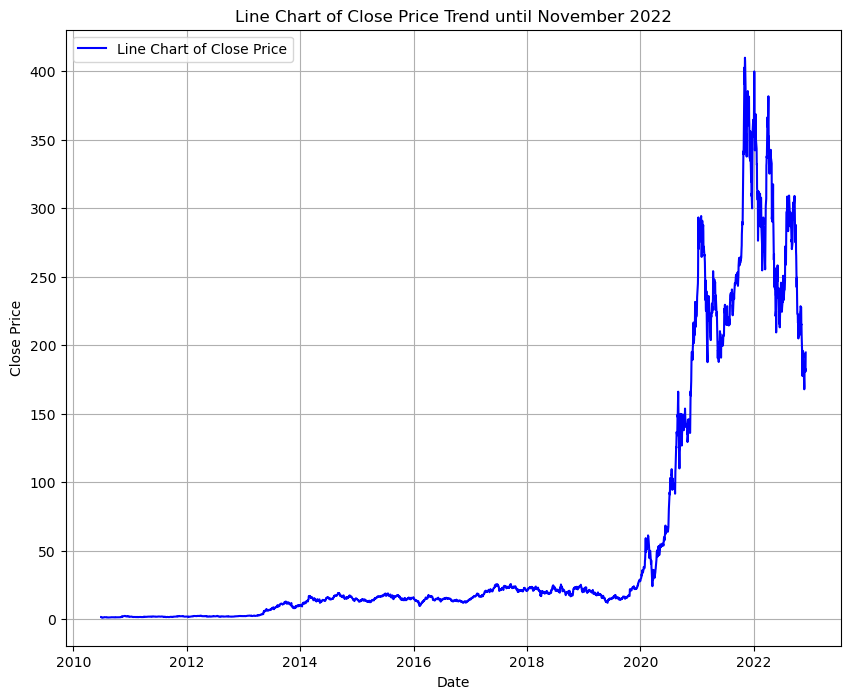

In [2]:
# Filter the data to show from start till "30-11-22"
filtered_data = data[:'2022-11-30']

# Plotting the filtered data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(filtered_data['Close'], label='Line Chart of Close Price', color='blue')
plt.title('Line Chart of Close Price Trend until November 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# ARIMA Model

In [11]:
# Fit the ARIMA model
arima_model = ARIMA(data['Close'], order=(5, 1, 0))
arima_model_fit = arima_model.fit()


C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\zains\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


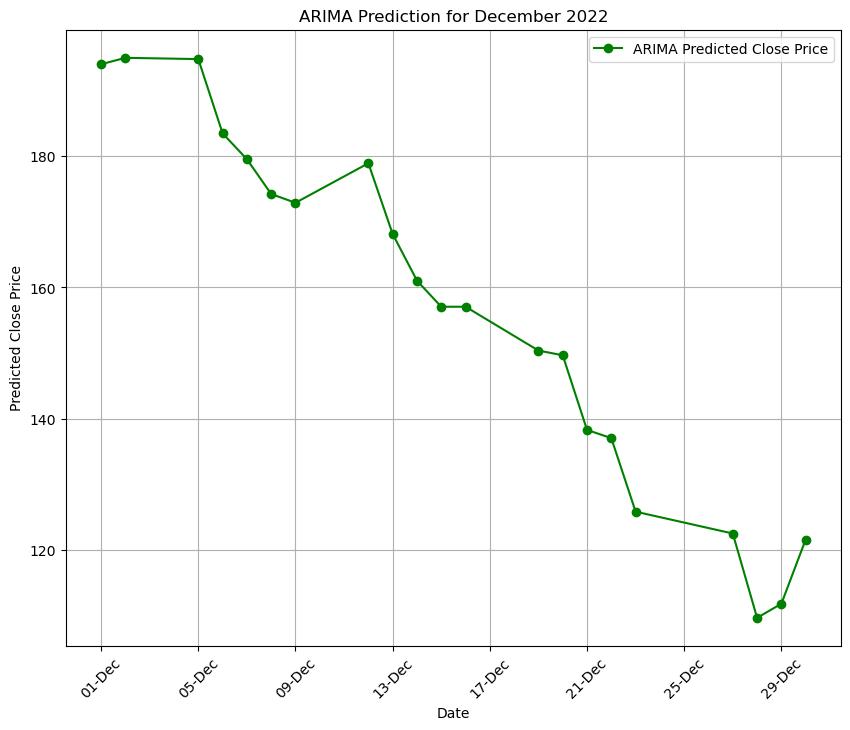

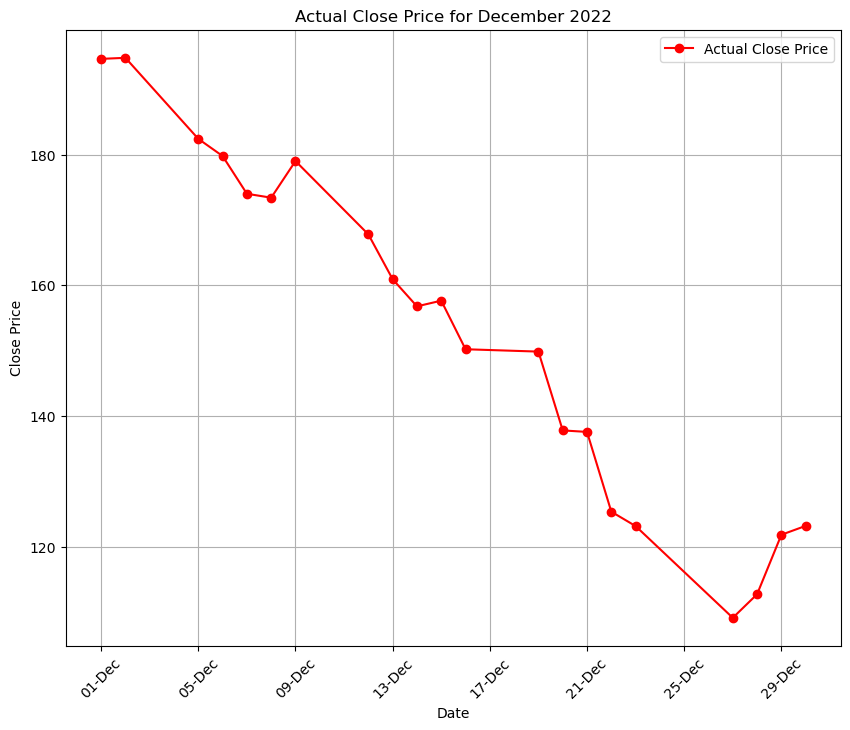

In [12]:
# Create a future dataframe for December 2022
start = '2022-12-01'
end = '2022-12-30'
arima_forecast = arima_model_fit.predict(start=start, end=end, dynamic=False)

# Plotting the forecast
plt.figure(figsize=(10, 8))
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Predicted Close Price', color='green', marker='o')
plt.title('ARIMA Prediction for December 2022')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))   # Format the x-axis to display only date and month
plt.xticks(rotation=45)  # Rotate the labels for better visibility
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Filter the data to show from start till "30-12-22"
actual_dec_2022 = data['2022-12-01':'2022-12-30']

# Plotting the actual data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(actual_dec_2022['Close'], label='Actual Close Price', color='red', marker='o')
plt.title('Actual Close Price for December 2022')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))   # Format the x-axis to display only date and month
plt.xticks(rotation=45)  # Rotate the labels for better visibility
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


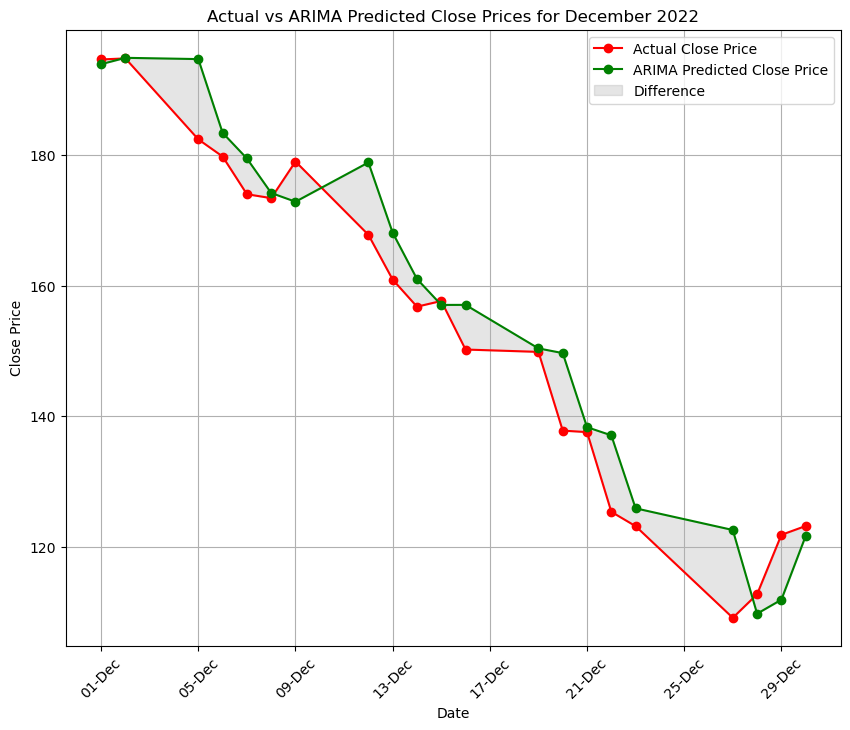

In [13]:
# Merge forecasted data with actual data
arima_comparison_df = actual_dec_2022[['Close']].join(arima_forecast.rename('yhat'), how='inner')

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 8))
plt.plot(arima_comparison_df.index, arima_comparison_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(arima_comparison_df.index, arima_comparison_df['yhat'], label='ARIMA Predicted Close Price', color='green', marker='o')
plt.title('Actual vs ARIMA Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(arima_comparison_df.index, arima_comparison_df['Close'], arima_comparison_df['yhat'], 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# Prophet Model

In [23]:
# Prepare the data for Prophet
prophet_data = data.reset_index()[['Date', 'Close']]
prophet_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_data)


02:13:40 - cmdstanpy - INFO - Chain [1] start processing
02:13:41 - cmdstanpy - INFO - Chain [1] done processing


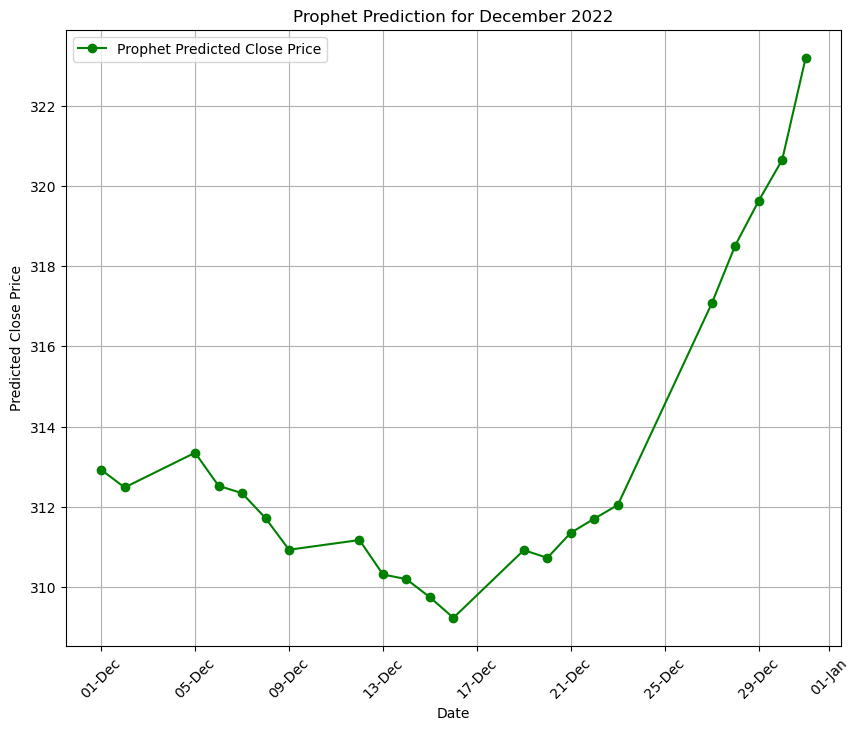

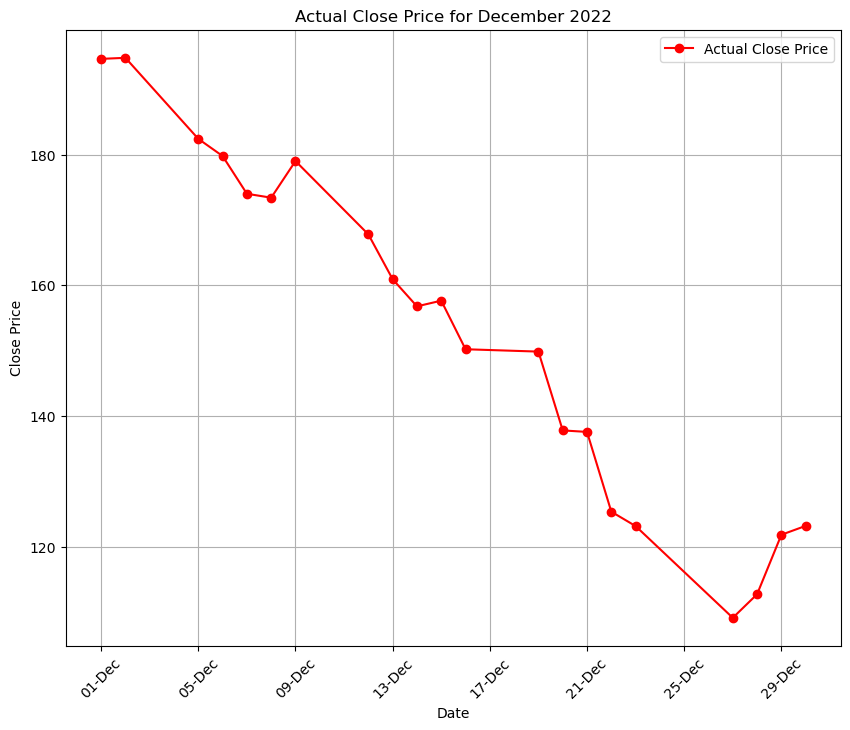

In [24]:
# Create a future dataframe for December 2022
future_dates = prophet_model.make_future_dataframe(periods=1, freq='D')
future_dates = future_dates[future_dates['ds'] >= '2022-12-01']  # Filter dates starting from December 1, 2022

# Forecast the future
forecast = prophet_model.predict(future_dates)

# Plotting the forecast
plt.figure(figsize=(10, 8))
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Predicted Close Price', color='green', marker='o')
plt.title('Prophet Prediction for December 2022')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))   # Format the x-axis to display only date and month
plt.xticks(rotation=45)  # Rotate the labels for better visibility
plt.ylabel('Predicted Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Filter the data to show from start till "30-12-22"
actual_dec_2022 = data['2022-12-01':'2022-12-30']

# Plotting the actual data as a line chart
plt.figure(figsize=(10, 8))
plt.plot(actual_dec_2022['Close'], label='Actual Close Price', color='red', marker='o')
plt.title('Actual Close Price for December 2022')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))   # Format the x-axis to display only date and month
plt.xticks(rotation=45)  # Rotate the labels for better visibility
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


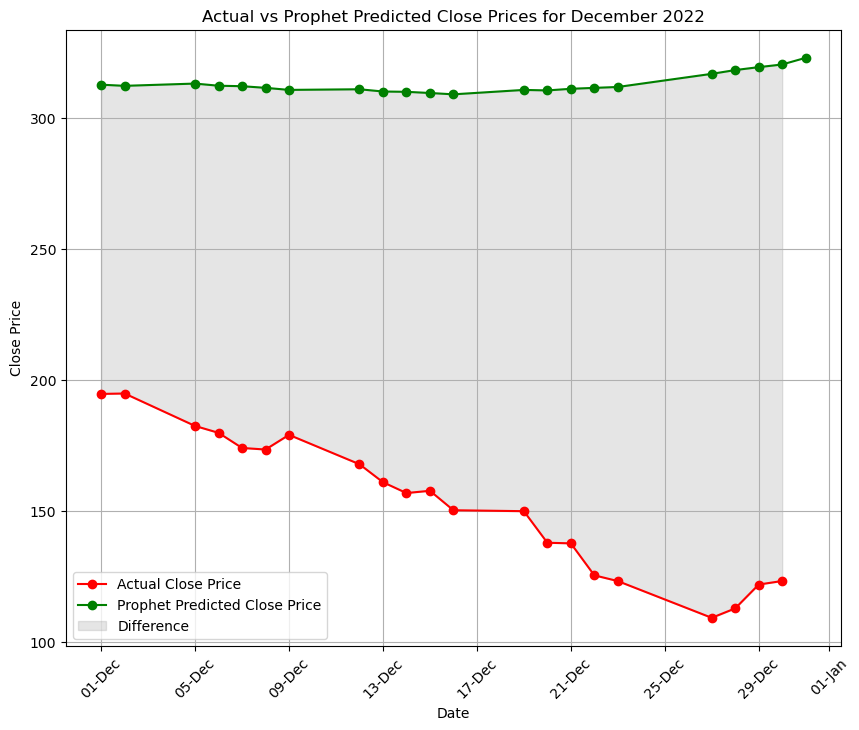

In [30]:
# Merge forecasted data with actual data
prophet_comparison_df = forecast.set_index('ds')[['yhat']].join(actual_dec_2022[['Close']])

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 8))
plt.plot(prophet_comparison_df.index, prophet_comparison_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(prophet_comparison_df.index, prophet_comparison_df['yhat'], label='Prophet Predicted Close Price', color='green', marker='o')
plt.title('Actual vs Prophet Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

# Fill between for a clearer comparison
plt.fill_between(prophet_comparison_df.index, prophet_comparison_df['Close'], prophet_comparison_df['yhat'], 
                 color='gray', alpha=0.2, label='Difference')

plt.legend()
plt.grid(True)
plt.show()


# Actual & Predicted Close Values

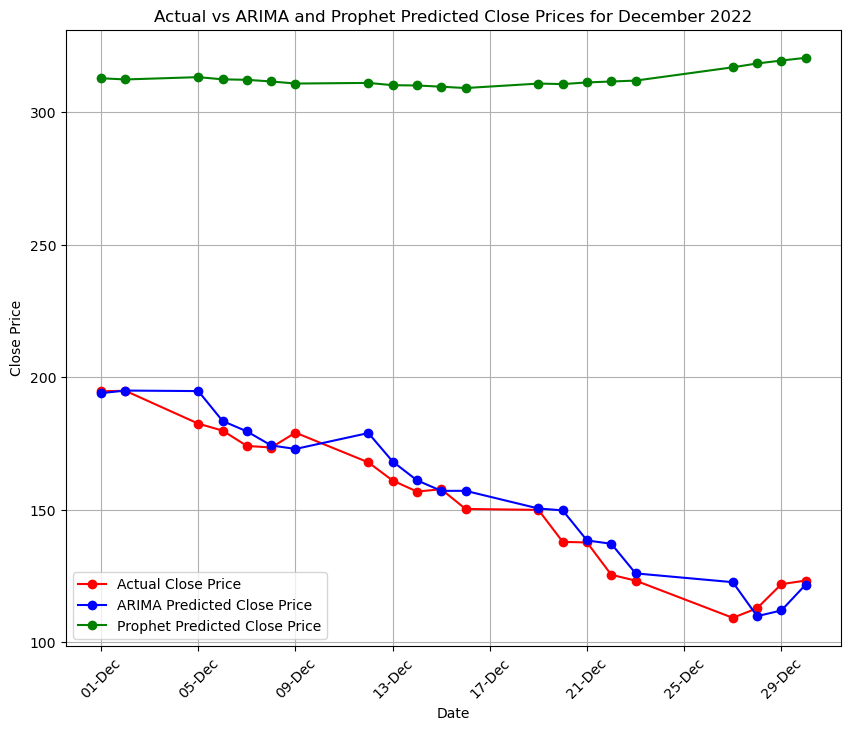

In [26]:
# Combine actual, ARIMA, and Prophet predictions for December 2022
combined_df = actual_dec_2022[['Close']].join(arima_forecast.rename('ARIMA'), how='inner').join(forecast.set_index('ds')[['yhat']].rename(columns={'yhat': 'Prophet'}))

# Plotting the combined data
plt.figure(figsize=(10, 8))
plt.plot(combined_df.index, combined_df['Close'], label='Actual Close Price', color='red', marker='o')
plt.plot(combined_df.index, combined_df['ARIMA'], label='ARIMA Predicted Close Price', color='blue', marker='o')
plt.plot(combined_df.index, combined_df['Prophet'], label='Prophet Predicted Close Price', color='green', marker='o')
plt.title('Actual vs ARIMA and Prophet Predicted Close Prices for December 2022')
plt.xlabel('Date')
plt.ylabel('Close Price')

# Format the x-axis to display only date and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)  # Rotate the labels for better visibility

plt.legend()
plt.grid(True)
plt.show()
